# Killer shrimp challenge
The goal of the challenge is to predict the presence of _Dikerogammarus Villosus_ and its spread in the Baltic Sea. D. Villosus is called "Killer Shrimp" and it's an invasive species.

### Dataset
The dataset contains the following variables:
- Presence = 0 or 1
- Salinity_today = water salinity at surface (0-2 meters, mean value over winter months, in parts per 1000)
- Temperature_today = water temperature at surface (mean value over winter months, in C)
- Substrate = substrate type (1 = sand, 0 = no sand)
- Depth = Depth of ocean
- Exposure = Wave exposure index at surface

### Output
The output dataset must contain pointid and predicted presence.

## Approach
Since this is a classification problem, I intend to use it as a learning tool to try to implement a Support Vector Machine model. This is something I read about but I never had the time to dive in it. It should be fun.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn import svm

### Data exploration and visualization

In [2]:
train_data_raw = pd.read_csv('../Datasets/killer-shrimp-invasion/train.csv')
test_data_raw = pd.read_csv('../Datasets/killer-shrimp-invasion/test.csv')

The dataset contains some NA. Where are the NA?

<AxesSubplot:>

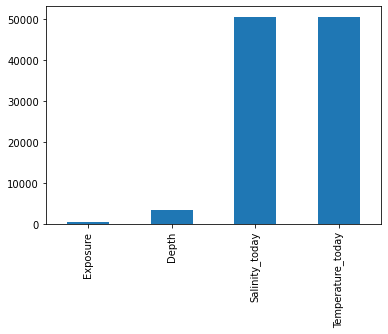

In [3]:
missing = train_data_raw.isna().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

There are more than 50'000 rows with missing data! Seemingly, mostly in Salinity and Temperature, but also a few in Depth and Exposure. When data is missing in salinity, it is also missing in temperature:

In [4]:
train_data_raw[train_data_raw['Temperature_today'].isna()].shape == train_data_raw[train_data_raw['Salinity_today'].isna()].shape

True

There are also many NAs in the test dataset (5622 rows). Here too it seems to be mainly in salinity, tempearture and a few in depth and exposure.

<AxesSubplot:>

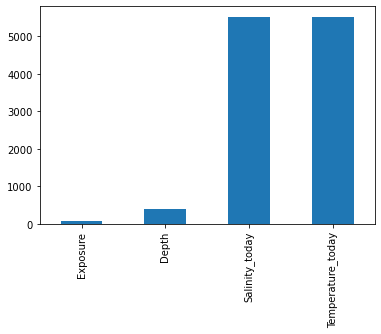

In [5]:
missing = test_data_raw.isna().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

From the look of it, the amount of NAs is proportional between train and test dataset.

Masking the NAs seems the better option. Then, it would be wise to first normalize the values and then mask. So let us split the dataset into features and labels:

In [6]:
features = ['Salinity_today', 'Temperature_today', 'Substrate', 'Depth', 'Exposure']
train_features = train_data_raw[features]
test_features = test_data_raw[features]
train_labels = train_data_raw['Presence']

### Data visualization
To start, I would like to plot Depth VS Exposure, and color the points based on their presence.

<AxesSubplot:xlabel='Exposure', ylabel='Depth'>

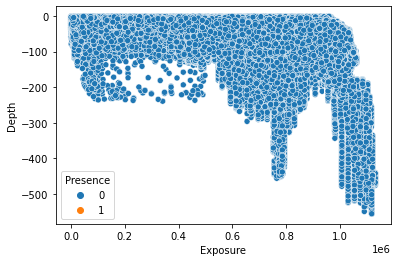

In [8]:
#sns.scatterplot(x='Exposure', y='Depth', data=train_data_raw, hue='Presence')

From running this, we can see that the actual number of data showing presence is incredibly small! How small exactly?

In [9]:
sum(train_data_raw['Presence'])

50

There are 50 (50!!) instances of presence. What the actual fuck?


My current mind for NAs is to encode whether a value is NA or not, then mask all NAs to a value. So let's start this: 

In [11]:
train_features[['Temperature_NA', 'Salinity_NA', 'Exposure_NA', 'Depth_NA']] = np.where(train_features[['Temperature_today', 'Salinity_today', 'Exposure', 'Depth']].isna(), 1, 0)
test_features[['Temperature_NA', 'Salinity_NA', 'Exposure_NA', 'Depth_NA']] = np.where(test_features[['Temperature_today', 'Salinity_today', 'Exposure', 'Depth']].isna(), 1, 0)

C:\Users\xtomma\AppData\Local\Temp\ipykernel_22008\3728023316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[['Temperature_NA', 'Salinity_NA', 'Exposure_NA', 'Depth_NA']] = np.where(train_features[['Temperature_today', 'Salinity_today', 'Exposure', 'Depth']].isna(), 1, 0)


Let's check whether this worked...

In [12]:
train_features[train_features.isna().any(axis=1)]

,Salinity_today,Temperature_today,Substrate,Depth,Exposure,Temperature_NA,Salinity_NA,Exposure_NA,Depth_NA
21,NaN,NaN,1.0,-1.659212,5374.0000,1,1,0,0
123,NaN,NaN,0.0,-8.157890,5057.2600,1,1,0,0
179,NaN,NaN,1.0,-8.849793,4107.5410,1,1,0,0
192,NaN,NaN,1.0,NaN,12528.6045,1,1,0,1
361,NaN,NaN,1.0,-3.481059,652.6757,1,1,0,0
...,...,...,...,...,...,...,...,...,...
2625807,NaN,NaN,1.0,-1.900000,3600.0000,1,1,0,0
2625834,NaN,NaN,1.0,-25.670000,8440.2340,1,1,0,0
2625941,NaN,NaN,1.0,-11.050000,9651.9790,1,1,0,0
2625972,NaN,NaN,1.0,-13.273676,7509.1094,1,1,0,0


Now let's mask the NAs. I reckon that the best guess should be something along the lines of a Z-normalization and then set Salinity_today and Temperature_today to 0. Thus, the NAs are set equal to the average value for these columns. We prefer this conversion so that mean() functions don't depend on NAs later on. Let's use .fillna() for this:

In [13]:
train_features = train_features.fillna(train_features.mean())
test_features = test_features.fillna(test_features.mean())

NAs are now masked and we need to use zscore from scipy stats, which without NAs is easy-peasy:

In [15]:
train_features[['Temperature_today', 'Salinity_today', 'Exposure', 'Depth']] = zscore(train_features[['Temperature_today', 'Salinity_today', 'Exposure', 'Depth']])
train_features

,Salinity_today,Temperature_today,Substrate,Depth,Exposure,Temperature_NA,Salinity_NA,Exposure_NA,Depth_NA
0,4.205202,1.574557,1.0,-1.129030,1.118138,0,0,0,0
1,-0.329235,-0.873348,0.0,1.084867,-2.071447,0,0,0,0
2,-0.131415,0.654580,1.0,-1.834676,0.449111,0,0,0,0
3,-0.844193,-2.003255,0.0,0.537998,-0.771578,0,0,0,0
4,-0.834558,-1.920401,1.0,0.243092,-0.769648,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2626039,-0.824457,-1.519434,1.0,0.175755,-0.530693,0,0,0,0
2626040,-0.019254,1.075992,1.0,0.307632,0.261339,0,0,0,0
2626041,-0.329558,-1.362766,1.0,1.120161,-2.101316,0,0,0,0
2626042,-0.422848,-0.694713,1.0,-0.473000,0.563193,0,0,0,0


Now we are ready for training whatever model we want. For this I chose a Support Vector Machine, so here goes.

In [16]:
model = svm.SVC()
model.fit(train_features, train_labels)

SVC()

And the predictions:

In [17]:
predictions = model.predict(test_features)

And finally we save the output and we are ready to submit it.

In [18]:
output = pd.DataFrame({'pointid': test_data_raw.pointid, 'Presence': predictions})
output.to_csv('killer_shrimp_svm.csv', index=False)

As it could be imagined, I scored pretty low with this approach. Still, it was more of a test and I intend to study the winning solution in detail, as it pertains to prediction of rare events (roughly 1 presence in 50'000 data points). 